## FFT 1D

 author : Sylvie Dagoret-Campagne
- aflilation IJCLab/IN2P3/CNRS
- creation date 2025-01-11
- last update : 2025-01-12
- doc on FFT : https://numpy.org/doc/2.0/reference/generated/numpy.fft.fft.html
- conda environnement : poppy_conda_py312 (on my macbook)
- install poppy : https://poppy-optics.readthedocs.io/en/latest/
- install rise in jupyterlab to see the slides : https://github.com/jupyterlab-contrib/rise
- install pandoc for documentation

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

In [2]:
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linestyle'] = '-'
mpl.rcParams['axes.titlesize'] =  24
mpl.rcParams['axes.labelsize'] =  20
mpl.rcParams['lines.markersize'] =  10
mpl.rcParams['xtick.labelsize'] =  16
mpl.rcParams['ytick.labelsize'] = 16

### Auxtel Configuration

In [3]:
# wavelength in m
wl = 0.5e-6
# pixel scale
# 10 microns pixel , 105 microns per arcsec
pix_scale = 10.0/105.0 # arcsec per pixel
fov_arcsec = 5.0 # must restrict the FOV in focl plane to avoid aliasing
# diameter in m
D = 1.2
Fnum = 18
# focal length
FL = D*Fnum
# Dccd
Dccd = 180e-3
# beam radius at object positon
beam_radius_m =  D/2/FL*Dccd
beam_radius_mm =  D/2/FL*Dccd*1000

In [4]:
beam_radius_mm

5.0

### Diffraction Pattern

In [5]:
Neff = 150
xmin = -0.05
xmax = 0.05
dxt = xmax-xmin

In [6]:
def set_ronchi_transmission_debug(x,opticalelement_nblines_permm=Neff):
    """
    Generate a square pattern of transmission.
    x in mm
    """
    a = 1/opticalelement_nblines_permm
    return np.rint(x/a-0.25 - np.floor(x/a-0.25))

Text(0.5, 0, 'mm')

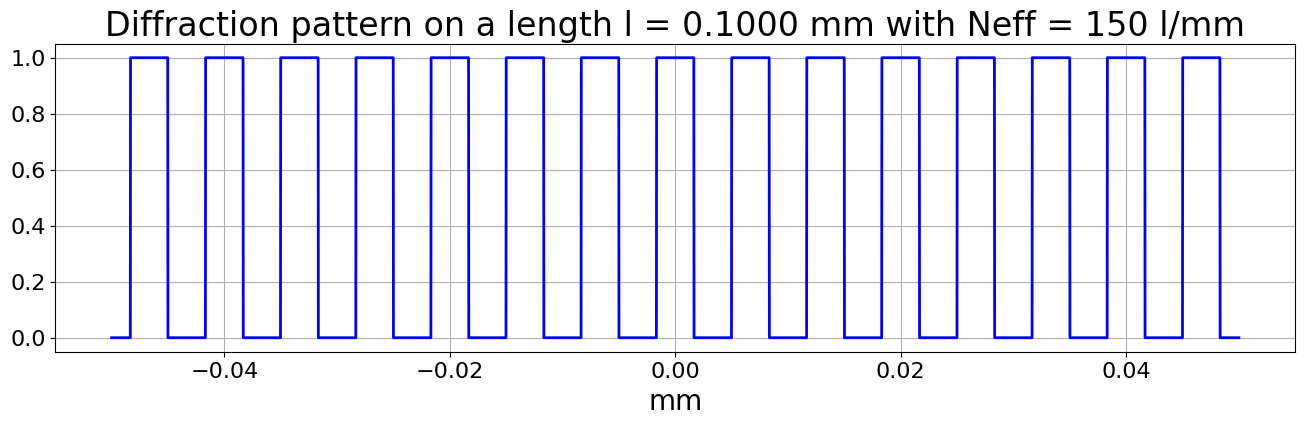

In [7]:
fig,ax = plt.subplots(1,1,figsize=(16,4))
x = np.linspace(-0.05,0.05,5000)
y = set_ronchi_transmission_debug(x)
ax.plot(x,y,'b-')
ax.grid()
ax.set_title(f"Diffraction pattern on a length l = {dxt:.4f} mm with Neff = {Neff} l/mm")
ax.set_xlabel("mm")

### Parameters of the FFT

In [8]:
Nb = 10001
padding_factor = 1.5

In [9]:
# x in units of mm
xe = np.linspace(-beam_radius_mm*padding_factor,+beam_radius_mm*padding_factor,Nb)
dxe = np.diff(xe).mean()
fe = 1/dxe
fmax = fe/2

In [10]:
print(f"Sampling distance dxe = {dxe} mm ")
print(f"Sampling frequency fe = {fe:.3f} mm -1")
print(f"Max signal requency fmax = {fmax:.3f} mm -1 before aliasing")
print(f"Beam radius = {beam_radius_mm} mm")
print(f"Beam radius frequency = {1/beam_radius_mm} mm-1")

Sampling distance dxe = 0.0015 mm 
Sampling frequency fe = 666.667 mm -1
Max signal requency fmax = 333.333 mm -1 before aliasing
Beam radius = 5.0 mm
Beam radius frequency = 0.2 mm-1


In [11]:
ye = set_ronchi_transmission_debug(xe)

In [12]:
# set padding on the borders
a = np.where(np.logical_or(xe<-beam_radius_mm,xe>beam_radius_mm),0,ye)

## Plots

### Plot the transmission pattern

Text(0.5, 0, 'mm')

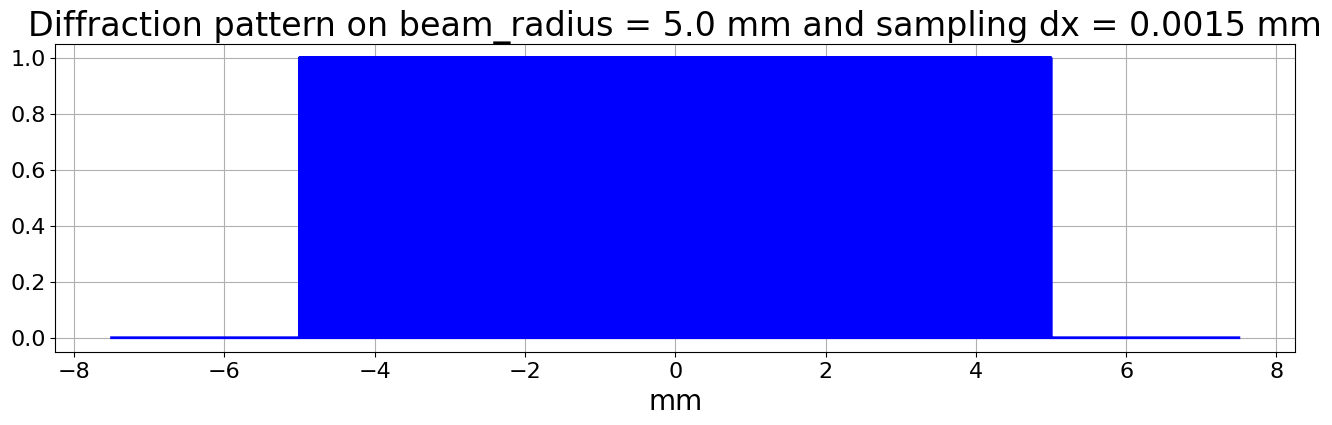

In [13]:
fig,ax = plt.subplots(1,1,figsize=(16,4))
ax.plot(xe,a,'b-')
ax.grid()
ax.set_title(f"Diffraction pattern on beam_radius = {beam_radius_mm} mm and sampling dx = {dxe:.4f} mm")
ax.set_xlabel("mm")

## Compute the FFT

In [14]:
sp = np.fft.fft(a)
# the frequency in units of mm^-1
freq = np.fft.fftfreq(a.shape[-1], d=dxe)
module = np.abs(sp)
phase = np.angle(sp)

### Plot FFT components
- a) real part
- b) imagniary part
- c) module
- d) phase

Text(0, 0.5, 'FFT phase')

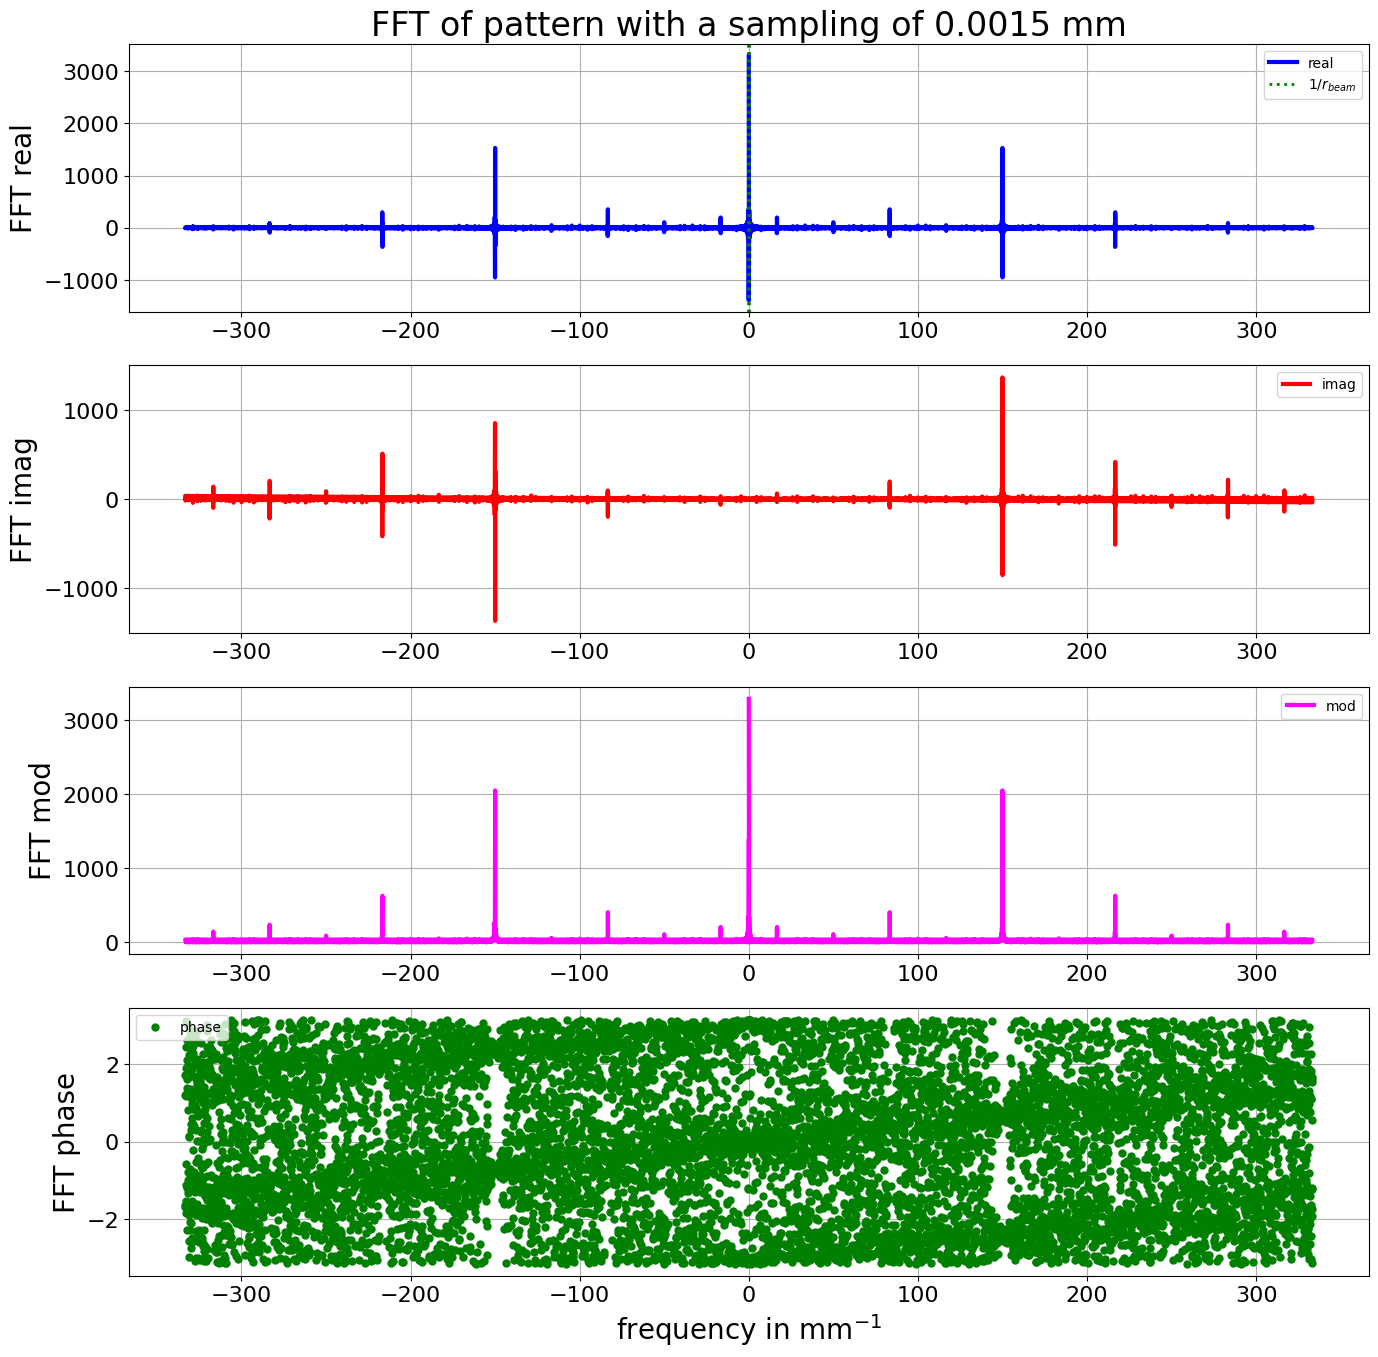

In [27]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(16,16),sharex=False)
ax1.plot(freq, sp.real, 'b',lw=3, label = "real")
ax1.grid()
ax1.set_title(f"FFT of pattern with a sampling of {dxe:.4f} mm")
ax1.axvline(x=1/beam_radius_mm,c="g",ls=":",label="$1/r_{beam}$")
ax1.axvline(x=-1/beam_radius_mm,c="g",ls=":")
ax2.plot(freq, sp.imag, 'r',lw=3, label = "imag")
ax2.grid()
ax3.plot(freq, module, c='magenta',lw=3, label = "mod")
ax3.grid()
ax4.plot(freq, phase,'.g',lw=3, label = "phase")
ax4.grid()
ax4.set_xlabel("frequency in mm$^{-1}$")
ax1.legend()
ax1.set_ylabel("FFT real")
ax2.legend()
ax2.set_ylabel("FFT imag")
ax3.legend()
ax3.set_ylabel("FFT mod")
ax4.legend()
ax4.set_ylabel("FFT phase")

### Plot the FFT coefficients in the aperture diffractive region

In [28]:
print(f"Beam radius = {beam_radius_mm} mm")
print(f"Beam radius frequency = {1/beam_radius_mm} mm-1")

Beam radius = 5.0 mm
Beam radius frequency = 0.2 mm-1


In the following plot, we see almost zero imaginary part due to the fact the function is pair.

Text(0.5, 1.0, 'First Fourier components')

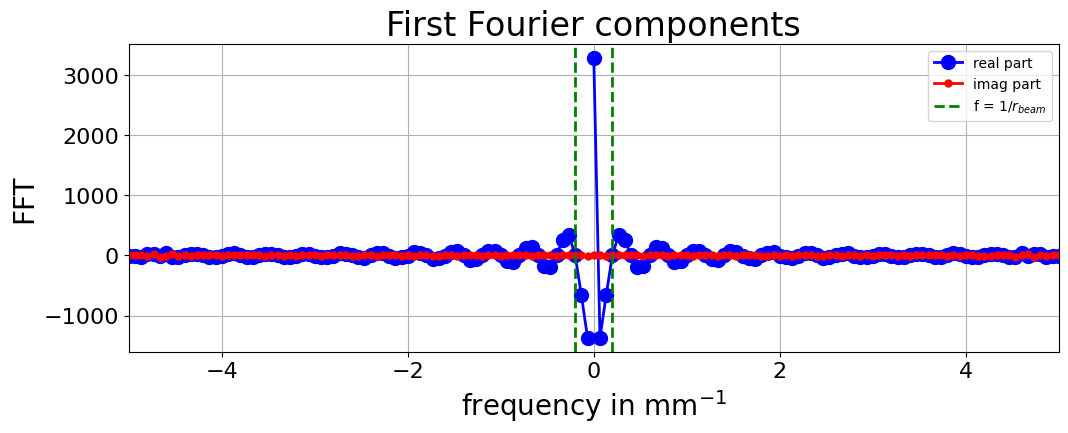

In [32]:
fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(freq,sp.real,marker="o",c="b",label="real part")
ax.plot(freq,sp.imag,marker=".",c="r",label="imag part")
ax.set_ylabel("FFT")
ax.set_xlim(-5,5)

ax.set_xlabel("frequency in mm$^{-1}$")
ax.axvline(x=1/beam_radius_mm,c="g",ls="--",label="f = $1/r_{beam}$")
ax.axvline(x=-1/beam_radius_mm,c="g",ls="--")
ax.grid()
ax.legend()
ax.set_title("First Fourier components")

### First Fourier components 

Text(0.5, 1.0, 'First coefficients of FFT')

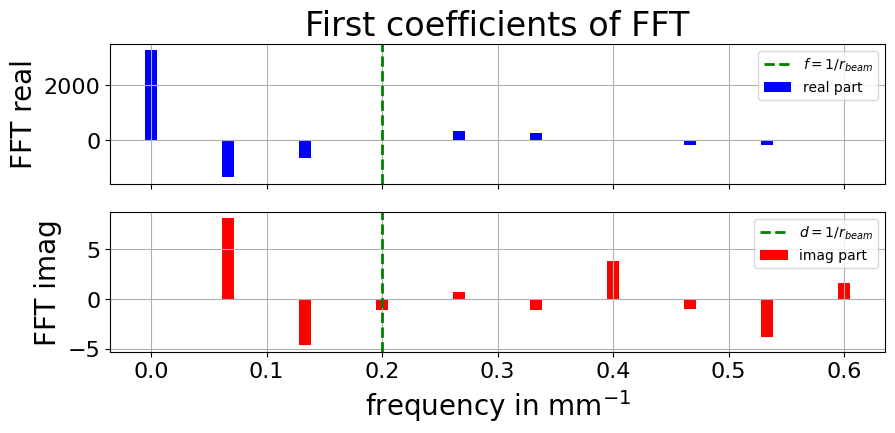

In [31]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(10,4),sharex=True)
ax1.bar(freq[0:10],sp.real[0:10],width=0.01,facecolor="b",label="real part")
ax2.bar(freq[0:10],sp.imag[0:10],width=0.01,facecolor="r",label="imag part")
ax1.set_ylabel("FFT real")
ax2.set_ylabel("FFT imag")
ax1.axvline(x=1/beam_radius_mm,c="g",ls="--",label="$f = 1/r_{beam}$")
ax2.axvline(x=1/beam_radius_mm,c="g",ls="--",label="$d = 1/r_{beam}$")
ax2.set_xlabel("frequency in mm$^{-1}$")
ax1.grid(); ax1.legend()
ax2.grid(); ax2.legend()
ax1.set_title("First coefficients of FFT")